## 1. Import Libraries

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import (
    OneHotEncoder, 
    MinMaxScaler, 
    StandardScaler,
    PowerTransformer,
    FunctionTransformer,
    OrdinalEncoder
)

from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder, 
    CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures

## 2. Display Settings

In [3]:
pd.set_option('display.max_columns',None)

>- Display settings force pandas to show all the columns each time if we import the data and vast columns we have then it can show less columns.

In [4]:
sklearn.set_config(transform_output='pandas')

>- So each times if we given an dataframe to sickit learn output returns in numpy array so this snippet helps to see that putput in dataframe itself.

In [5]:
import warnings
warnings.filterwarnings("ignore")

## 3. Read The Data

In [6]:
path = r'C:\Users\admin\OneDrive\Desktop\Flights_SageMaker_Project\Data\train.csv'

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-06,Delhi,Cochin,14:20:00,22:30,490,1.0,No Info,6938
1,Multiple Carriers,2019-06-15,Delhi,Cochin,11:30:00,19:15,465,1.0,No Info,16108
2,Jet Airways,2019-05-12,Kolkata,Banglore,17:00:00,22:05,1745,1.0,No Info,13067
3,Air India,2019-05-09,Delhi,Cochin,14:25:00,19:15,1730,2.0,No Info,13591
4,Air India,2019-03-06,Mumbai,Hyderabad,12:45:00,19:25,1840,2.0,No Info,13253
...,...,...,...,...,...,...,...,...,...,...
635,Multiple Carriers,2019-05-18,Delhi,Cochin,10:20:00,19:00,520,1.0,No Info,9794
636,Jet Airways,2019-05-21,Delhi,Cochin,08:00:00,04:25,1225,1.0,In-flight meal not included,12898
637,Jet Airways,2019-05-24,Kolkata,Banglore,09:35:00,09:45,1450,1.0,No Info,13067
638,Indigo,2019-06-12,Banglore,Delhi,07:10:00,10:05,175,0.0,No Info,4823


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [8]:
X_train = train.drop(columns='price')
y_train = train['price'].copy()

## 4. Transformation Operations

### 4.1 Airline

In [9]:
X_train.airline

0                 Indigo
1      Multiple Carriers
2            Jet Airways
3              Air India
4              Air India
             ...        
635    Multiple Carriers
636          Jet Airways
637          Jet Airways
638               Indigo
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [10]:
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with='other', n_categories=2)),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(train.loc[:,['airline']])#.columns.str.replace(" ","_")

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_other
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
635,0.0,0.0,0.0,1.0,0.0
636,0.0,0.0,1.0,0.0,0.0
637,0.0,0.0,1.0,0.0,0.0
638,0.0,1.0,0.0,0.0,0.0


>- tol :Tolerance used in RareLabelEncoder that helps to group the categories which are less than 10%

### 4.2 date_of_journey

In [11]:
X_train.date_of_journey

0      2019-06-06
1      2019-06-15
2      2019-05-12
3      2019-05-09
4      2019-03-06
          ...    
635    2019-05-18
636    2019-05-21
637    2019-05-24
638    2019-06-12
639    2019-06-15
Name: date_of_journey, Length: 640, dtype: object

In [12]:
feature_to_extract = ['month','week', 'day_of_week','day_of_year']

doj_transformer = Pipeline(steps=[
    ('dt', DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format='mixed')),
    ("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train[['date_of_journey']])#.date_of_journey_week.value_counts()

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,0.823529,0.500000,0.822034
1,1.000000,0.882353,0.833333,0.898305
2,0.666667,0.588235,1.000000,0.610169
3,0.666667,0.588235,0.500000,0.584746
4,0.000000,0.058824,0.333333,0.042373
...,...,...,...,...
635,0.666667,0.647059,0.833333,0.661017
636,0.666667,0.705882,0.166667,0.686441
637,0.666667,0.705882,0.666667,0.711864
638,1.000000,0.882353,0.333333,0.872881


### 4.3 source & destination

In [13]:
X_train.source

0         Delhi
1         Delhi
2       Kolkata
3         Delhi
4        Mumbai
         ...   
635       Delhi
636       Delhi
637     Kolkata
638    Banglore
639       Delhi
Name: source, Length: 640, dtype: object

In [14]:
X_train.destination

0         Cochin
1         Cochin
2       Banglore
3         Cochin
4      Hyderabad
         ...    
635       Cochin
636       Cochin
637     Banglore
638        Delhi
639       Cochin
Name: destination, Length: 640, dtype: object

In [15]:
location_subset = X_train.loc[:,['source','destination']]
location_subset

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Kolkata,Banglore
3,Delhi,Cochin
4,Mumbai,Hyderabad
...,...,...
635,Delhi,Cochin
636,Delhi,Cochin
637,Kolkata,Banglore
638,Banglore,Delhi


In [16]:
location_pipe1 = Pipeline(steps=[
    ('grouper', RareLabelEncoder(tol=0.1, replace_with='other', n_categories=2)),
    ('mean_encoding', MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,1.033319,1.031179
1,1.033319,1.031179
2,-0.013882,-0.064799
3,1.033319,1.031179
4,-1.749644,-0.819113
...,...,...
635,1.033319,1.031179
636,1.033319,1.031179
637,-0.013882,-0.064799
638,-1.050080,-1.743092


>- Mean Encoding : Mean encoding means lets say we have cateorgies like cat1 ,2 and 3 adn target column price.
>- So, Mean encoding takes first category and then look over all possible categories of cat1 takes corresponding price values and cal its average.
>- That average will be the mean encoding for cat1 as we calculate for each category.

>- **Importance of using these techqniue**:  Beacuse as categorical variable builds strog relation with target column that helps to improce the model performance.
>- It helps to reduce the high cardinality.
>- It can handle the ordinal features also by preserving there inherent order

>- Power Transformer : Were used to convert the data as symmetric as possible.
>- Inside power Transformer we can make standardize = True that helps to normalize the values.

In [17]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [18]:
def is_north(x):
    columns = x.columns.to_list()
    north_cities = ['Delhi', 'New Delhi']
    return (
        x.assign(**{
            f"{col}_is_north": x.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,0,0
3,1,0
4,0,0
...,...,...
635,1,0
636,1,0
637,0,0
638,0,1


>- Functions were not able to implement in pipelines so we have to convert them as scikit learn compatible form.
>- After that we can pass function name we can easily use in pipelines.

In [19]:
location_transform = FeatureUnion(transformer_list=[
    ('part1', location_pipe1),
    ('part2', FunctionTransformer(func=is_north))
])

location_transform.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,1.033319,1.031179,1,0
1,1.033319,1.031179,1,0
2,-0.013882,-0.064799,0,0
3,1.033319,1.031179,1,0
4,-1.749644,-0.819113,0,0
...,...,...,...,...
635,1.033319,1.031179,1,0
636,1.033319,1.031179,1,0
637,-0.013882,-0.064799,0,0
638,-1.050080,-1.743092,0,1


>- **FeatureUnion**: Were used to conactenate multiple transformed features together.

### 4.4 dep_time & arrival_time

In [20]:
X_train.dep_time

0      14:20:00
1      11:30:00
2      17:00:00
3      14:25:00
4      12:45:00
         ...   
635    10:20:00
636    08:00:00
637    09:35:00
638    07:10:00
639    18:15:00
Name: dep_time, Length: 640, dtype: object

In [21]:
X_train.arrival_time

0      22:30
1      19:15
2      22:05
3      19:15
4      19:25
       ...  
635    19:00
636    04:25
637    09:45
638    10:05
639    12:35
Name: arrival_time, Length: 640, dtype: object

In [22]:
time_subset = X_train[['dep_time','arrival_time']]
time_subset

,dep_time,arrival_time
0,14:20:00,22:30
1,11:30:00,19:15
2,17:00:00,22:05
3,14:25:00,19:15
4,12:45:00,19:25
...,...,...
635,10:20:00,19:00
636,08:00:00,04:25
637,09:35:00,09:45
638,07:10:00,10:05


In [23]:
time_pipe1 = Pipeline(steps=[
    ('dt', DatetimeFeatures(features_to_extract=['hour','minute'])),
    ('Mm', MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.608696,0.363636,0.956522,0.545455
1,0.478261,0.545455,0.826087,0.272727
2,0.739130,0.000000,0.956522,0.090909
3,0.608696,0.454545,0.826087,0.272727
4,0.521739,0.818182,0.826087,0.454545
...,...,...,...,...
635,0.434783,0.363636,0.826087,0.000000
636,0.347826,0.000000,0.173913,0.454545
637,0.391304,0.636364,0.391304,0.818182
638,0.304348,0.181818,0.434783,0.090909


In [24]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col : pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:,col].between(morning, noon, inclusive='left'),
                X_temp.loc[:,col].between(noon, eve, inclusive='left'),
                X_temp.loc[:,col].between(eve, night, inclusive='left')],
                ['morning', 'afternoon', 'evening'],
                default = 'night'
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,afternoon,night
1,morning,evening
2,evening,night
3,afternoon,evening
4,afternoon,evening
...,...,...
635,morning,evening
636,morning,morning
637,morning,morning
638,morning,morning


In [25]:
time_pipe2 = Pipeline(steps=[
    ('part', FunctionTransformer(func=part_of_day)),
    ('encoder', CountFrequencyEncoder()),
    ('scaler', MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.000000,0.85
1,1.000000,0.39
2,0.204167,0.85
3,0.000000,0.39
4,0.000000,0.39
...,...,...
635,1.000000,0.39
636,1.000000,1.00
637,1.000000,1.00
638,1.000000,1.00


>- **Count Encoding** : So in this concept each category will be replace by there occurances.
    
>- **Why we use** : 1) As we know that machine understand the numebrs thats y.
                    2) It makes simplicity to uuderstand.
                    3) As we know that using OHE may leads towards so many numbers of featurs if we have high cardinality. So this cocept works well also wont leads towards multi-collinearity.

>- **Impact** : 1) It can reatins some useful info like frequency.
                2) So it also intrdouce the high biaseness , which is not desirable.
                3) Reduces Multicollineairty.

In [26]:
time_transformer = FeatureUnion(transformer_list=[
    ('part1', time_pipe1),
    ('part2', time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.608696,0.363636,0.956522,0.545455,0.000000,0.85
1,0.478261,0.545455,0.826087,0.272727,1.000000,0.39
2,0.739130,0.000000,0.956522,0.090909,0.204167,0.85
3,0.608696,0.454545,0.826087,0.272727,0.000000,0.39
4,0.521739,0.818182,0.826087,0.454545,0.000000,0.39
...,...,...,...,...,...,...
635,0.434783,0.363636,0.826087,0.000000,1.000000,0.39
636,0.347826,0.000000,0.173913,0.454545,1.000000,1.00
637,0.391304,0.636364,0.391304,0.818182,1.000000,1.00
638,0.304348,0.181818,0.434783,0.090909,1.000000,1.00


### 4.5 duration

In [27]:
X_train.duration

0       490
1       465
2      1745
3      1730
4      1840
       ... 
635     520
636    1225
637    1450
638     175
639    1100
Name: duration, Length: 640, dtype: int64

In [28]:
(
    X_train
    .duration
    .quantile([0.25,0.5,0.75])
    .values
    .reshape(-1,1)
    # .shape
)

array([[170. ],
       [497.5],
       [965. ]])

In [29]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

>- For each specified column, creates new columns indicating how similar each value in the original column is to the calculated reference values (percentiles) using the RBF kernel.
>- The new columns are named based on the original column name and the percentile (e.g., col_rbf_25 for the 25th percentile).
>- Combines these new columns into a single DataFrame and returns it.

>- In summary, this class transforms numerical columns into new features that represent the similarity of each value to certain percentiles of that column using the RBF kernel method.

In [30]:
RBFPercentileSimilarity().fit_transform(X_train[['duration']])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.000000,3.606563e-03,0.0
1,0.000000,1.341669e-46,0.0
2,0.000000,0.000000e+00,0.0
3,0.000000,0.000000e+00,0.0
4,0.000000,0.000000e+00,0.0
...,...,...,...
635,0.000000,1.032385e-22,0.0
636,0.000000,0.000000e+00,0.0
637,0.000000,0.000000e+00,0.0
638,0.082085,0.000000e+00,0.0


>- **RBF Kernel**: Were used to calculate the relation between two values. The input variable and target columns --> qunatiles of durations.
>- Simply we calculate the qunatiles and how close the values with this qunatiles values.
>- We are going to use Skleanrs RBF Kernel from skleanr.metrics. 
>- We have to specify the X and Y -- X : n x p --> n = number of observations and p = number of input variables. Y : m x p --> refernece values m = number of refernce values : means how many values we are going to compare with input values to calcualte RBF.

In [31]:
def duration_category(X, short = 180, med = 400):
    return (
        X
        .assign(
            duration_cat=np.select(
                [X.duration.lt(short),
                 X.duration.between(short, med, inclusive='left')],
                ['short','medium'],
                default = 'long'
            )
        )
        .drop(columns='duration')
    )

# duration_category(X_train.loc[:,['duration']])

In [32]:
def is_over(X, value=1000):
    return (
        X
        .assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)
        })
        .drop(columns='duration')
    )
# is_over(X_train.loc[:,['duration']])

In [33]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.411171,4.536830,-0.105521,2.0,0,-0.289409
1,-0.411171,-0.121773,-0.105521,2.0,0,-0.338552
2,-0.411171,-0.121773,-0.105521,2.0,1,2.177531
3,-0.411171,-0.121773,-0.105521,2.0,1,2.148046
4,-0.411171,-0.121773,-0.105521,2.0,1,2.364272
...,...,...,...,...,...,...
635,-0.411171,-0.121773,-0.105521,2.0,0,-0.230439
636,-0.411171,-0.121773,-0.105521,2.0,1,1.155373
637,-0.411171,-0.121773,-0.105521,2.0,1,1.597653
638,1.978845,-0.121773,-0.105521,0.0,0,-0.908602


>- **Winsorizer** : It is an outlier handling Technqiue according to the distribution of the data.
>- It is an class avialble in feature_engine.outliers import Winsorizer.

### 4.6 total_stops

In [34]:
X_train.total_stops

0      1.0
1      1.0
2      1.0
3      2.0
4      2.0
      ... 
635    1.0
636    1.0
637    1.0
638    0.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [35]:
def is_direct(X):
	return (
        X
        .assign(
            is_direct_flight=X.total_stops.eq(0).astype(int)
        )
                
    )


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("dircet_flight", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,1.0,0
3,2.0,0
4,2.0,0
...,...,...
635,1.0,0
636,1.0,0
637,1.0,0
638,0.0,1


>- eq : used in assign method for checking if eq == 0 then True otherwise False

### 4.7 additional_info

In [36]:
X_train.additional_info

0                          No Info
1                          No Info
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636    In-flight meal not included
637                        No Info
638                        No Info
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [37]:
info_pipe1 = Pipeline(steps=[
    ('grouper', RareLabelEncoder(tol=0.1, n_categories=2, replace_with='others')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

info_pipe1.fit_transform(X_train.loc[:,['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_others
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,1.0,0.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [38]:
def have_info(X):
    return (
        X
        .assign(
            additional_info= X.additional_info.ne('No Info').astype(int)
        )
    )
have_info(X_train.loc[:,['additional_info']])

,additional_info
0,0
1,0
2,0
3,0
4,0
...,...
635,0
636,1
637,0
638,0


>- have info : used to build a new feature or modified existing faetures --> assign values for category.
>- ne method used in this case which indiactes not equal to != 'No Info' then it will return an boolean value.
>- Further it will convert True = 1 and False = 0.
>- additional_info column contains information other than "No Info". Specifically, it will be 1 if there is additional information (i.e., the value is not "No Info") and 0 if there is no additional information (i.e., the value is "No Info").

In [39]:
info_union = FeatureUnion(transformer_list=[
    ('part1', info_pipe1),
    ('part2', FunctionTransformer(func=have_info))
])

info_union.fit_transform(X_train.loc[:,['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_others,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,1.0,0.0,0.0,1
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


In [40]:
info_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('union', info_union)
])

info_transformer.fit_transform(X_train.loc[:,['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_others,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,1.0,0.0,0.0,1
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


## 5. Column Transformer

In [41]:
column_transformer = ColumnTransformer(transformers=[
    ('air', air_transformer, ['airline']),
    ('doj', doj_transformer,['date_of_journey']),
    ('location', location_transform,['source','destination']),
    ('time', time_transformer, ['dep_time','arrival_time']),
    ('dur', duration_transformer, ['duration']),
    ('stops', total_stops_transformer, ['total_stops']),
    ('info', info_transformer, ['additional_info'])
    
], remainder='passthrough')

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_others,info__additional_info
0,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,1.033319,1.031179,1,0,0.608696,0.363636,0.956522,0.545455,0.000000,0.85,-0.411171,4.536830,-0.105521,2.0,0,-0.289409,1.0,0,0.0,1.0,0.0,0
1,0.0,0.0,0.0,1.0,0.0,1.000000,0.882353,0.833333,0.898305,1.033319,1.031179,1,0,0.478261,0.545455,0.826087,0.272727,1.000000,0.39,-0.411171,-0.121773,-0.105521,2.0,0,-0.338552,1.0,0,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,1.000000,0.610169,-0.013882,-0.064799,0,0,0.739130,0.000000,0.956522,0.090909,0.204167,0.85,-0.411171,-0.121773,-0.105521,2.0,1,2.177531,1.0,0,0.0,1.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,0.666667,0.588235,0.500000,0.584746,1.033319,1.031179,1,0,0.608696,0.454545,0.826087,0.272727,0.000000,0.39,-0.411171,-0.121773,-0.105521,2.0,1,2.148046,2.0,0,0.0,1.0,0.0,0
4,1.0,0.0,0.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,-1.749644,-0.819113,0,0,0.521739,0.818182,0.826087,0.454545,0.000000,0.39,-0.411171,-0.121773,-0.105521,2.0,1,2.364272,2.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,1.0,0.0,0.666667,0.647059,0.833333,0.661017,1.033319,1.031179,1,0,0.434783,0.363636,0.826087,0.000000,1.000000,0.39,-0.411171,-0.121773,-0.105521,2.0,0,-0.230439,1.0,0,0.0,1.0,0.0,0
636,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,1.033319,1.031179,1,0,0.347826,0.000000,0.173913,0.454545,1.000000,1.00,-0.411171,-0.121773,-0.105521,2.0,1,1.155373,1.0,0,1.0,0.0,0.0,1
637,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.666667,0.711864,-0.013882,-0.064799,0,0,0.391304,0.636364,0.391304,0.818182,1.000000,1.00,-0.411171,-0.121773,-0.105521,2.0,1,1.597653,1.0,0,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,-1.050080,-1.743092,0,1,0.304348,0.181818,0.434783,0.090909,1.000000,1.00,1.978845,-0.121773,-0.105521,0.0,0,-0.908602,0.0,1,0.0,1.0,0.0,0


## 6. Feature Selection

In [42]:
estimator = RandomForestRegressor(n_estimators=10,max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
    estimator=estimator, 
    scoring='r2', 
    threshold=0.1
)

>- **SelectBySingleFeatureperformance** : It is an feature selection algo wheather used to select features on basis of there top score and reatines the less core features.
>- It applies estimator on single variable with target column and finds the best features from them.

## 6. Putting it all Together

In [43]:
preprocessor = Pipeline(steps=[
    ('ct', column_transformer),
    ('selector', selector)
])

preprocessor.fit_transform(X_train,y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,1.0,0.0,0.0,0.823529,0.822034,1.033319,1.031179,-0.411171,2.0,0,-0.289409,1.0,0
1,0.0,0.0,0.0,0.882353,0.898305,1.033319,1.031179,-0.411171,2.0,0,-0.338552,1.0,0
2,0.0,1.0,0.0,0.588235,0.610169,-0.013882,-0.064799,-0.411171,2.0,1,2.177531,1.0,0
3,0.0,0.0,0.0,0.588235,0.584746,1.033319,1.031179,-0.411171,2.0,1,2.148046,2.0,0
4,0.0,0.0,0.0,0.058824,0.042373,-1.749644,-0.819113,-0.411171,2.0,1,2.364272,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.647059,0.661017,1.033319,1.031179,-0.411171,2.0,0,-0.230439,1.0,0
636,0.0,1.0,0.0,0.705882,0.686441,1.033319,1.031179,-0.411171,2.0,1,1.155373,1.0,0
637,0.0,1.0,0.0,0.705882,0.711864,-0.013882,-0.064799,-0.411171,2.0,1,1.597653,1.0,0
638,1.0,0.0,0.0,0.882353,0.872881,-1.050080,-1.743092,1.978845,0.0,0,-0.908602,0.0,1


## 7. Visulaizations

In [50]:
# lets see which columns are drop and retains.

feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.0341624073625156,
 'air__airline_Indigo': 0.14820290567512615,
 'air__airline_Jet Airways': 0.135028748023179,
 'air__airline_Multiple Carriers': 0.025560494476172407,
 'air__airline_other': 0.13889688426395064,
 'doj__date_of_journey_month': 0.08454720664421111,
 'doj__date_of_journey_week': 0.1460122798535305,
 'doj__date_of_journey_day_of_week': -0.009667332032710122,
 'doj__date_of_journey_day_of_year': 0.17448782742967095,
 'location__source': 0.13565089443094736,
 'location__destination': 0.16898049532118986,
 'location__source_is_north': 0.08608357115536676,
 'location__destination_is_north': 0.03138602934574116,
 'time__dep_time_hour': 0.02574033846514175,
 'time__dep_time_minute': 0.02922935444979191,
 'time__arrival_time_hour': 0.024896002190289018,
 'time__arrival_time_minute': 0.03762588083644913,
 'time__dep_time_part_of_day': 0.005457348088580227,
 'time__arrival_time_part_of_day': 0.007372520545977183,
 'dur__duration_rbf_25': 0.1696396999273

In [59]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val:val[1], reverse=True))
sorted_feat_imp

{'dur__duration': 0.5093220468802586,
 'dur__duration_cat': 0.4933470374857218,
 'stops__total_stops': 0.46353685566816355,
 'stops__is_direct_flight': 0.4348114239828975,
 'dur__duration_over_1000': 0.1919598909151274,
 'doj__date_of_journey_day_of_year': 0.17448782742967095,
 'dur__duration_rbf_25': 0.16963969992731787,
 'location__destination': 0.16898049532118986,
 'air__airline_Indigo': 0.14820290567512615,
 'doj__date_of_journey_week': 0.1460122798535305,
 'air__airline_other': 0.13889688426395064,
 'location__source': 0.13565089443094736,
 'air__airline_Jet Airways': 0.135028748023179,
 'location__source_is_north': 0.08608357115536676,
 'doj__date_of_journey_month': 0.08454720664421111,
 'info__additional_info_others': 0.0448179675168375,
 'time__arrival_time_minute': 0.03762588083644913,
 'air__airline_Air India': 0.0341624073625156,
 'location__destination_is_north': 0.03138602934574116,
 'time__dep_time_minute': 0.02922935444979191,
 'time__dep_time_hour': 0.02574033846514175

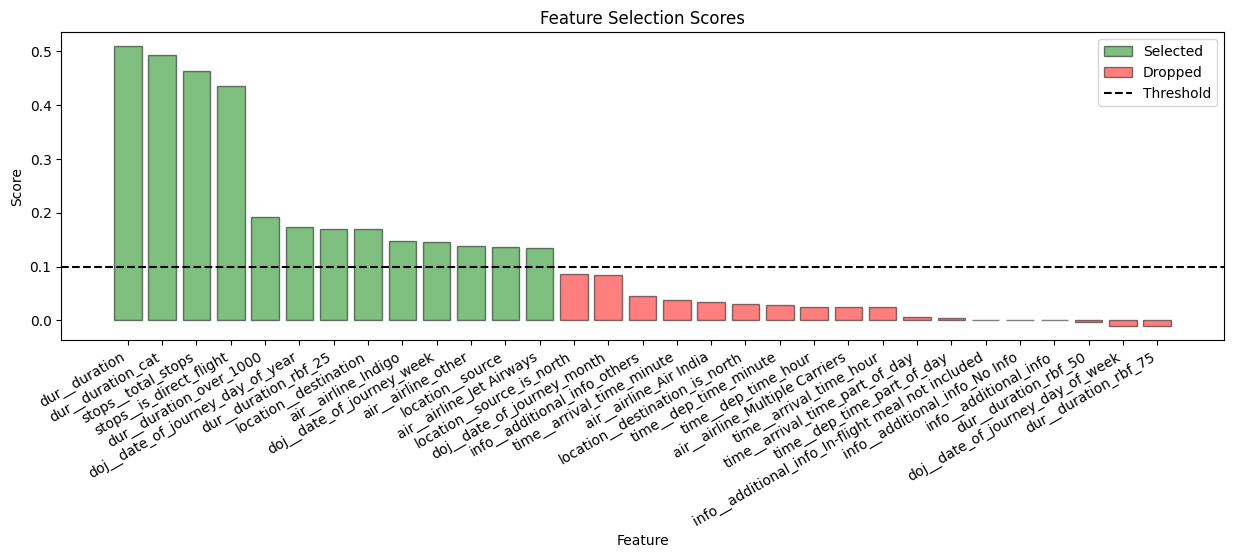

In [72]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper right"
)

plt.show()